In [131]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sb

import os
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB

import re
import emoji

from collections import Counter
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from nltk import FreqDist
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, CuDNNLSTM, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, Dropout, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shaoxing/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shaoxing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading dataset

In [132]:
## directory of dataset
root="/Users/shaoxing/Desktop/dataset/"

In [133]:
##read train set
train_dataset = pd.read_csv(root+'offenseval-training-v1.tsv' , sep='\t')
train_dataset.drop(['id'], axis=1, inplace = True)


In [134]:
## read the tast dataset
test_data = pd.read_csv(root+'testset-levelc.tsv' , sep='\t') 
test_labels=pd.read_csv(root+'labels-levelc.csv' , sep='\t') 

test_labels=np.array(test_labels)

test_labels=np.insert(test_labels,0,['15923,OTH'])
labels=[]
for item in test_labels:
    labels.append(item.split(",")[1])

labels=pd.DataFrame(labels, columns=["subtask_c"])

test_dataset = pd.concat([test_data, labels], axis=1)

## Dataset Preprocessing 

In [135]:
def emojiPreprocessing(text):
    
    text = emoji.demojize(text)
    
    text = re.compile("([\U0001f3fb-\U0001f3ff])").sub(r'',text) 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r'',text) 
    text = re.compile("(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])").sub(r'',text)

   
    text = re.compile("([\U00010000-\U0010ffff])").sub(r' \1 ',text) 
    return text

In [136]:
def tweetPreprocessing (text):
    
    
    text = re.compile(r'@USER').sub(r'<user>',text)# Replace @USER by <user>

    
    text = re.compile(r'URL').sub(r'<url>',text)# Replace URL by <url>

    
    text = re.compile(r'[0-9]+').sub(r' ',text)# Remove numbers :

    
    text = re.compile(r'([\xa0_\{\}\[\]¬•$,:;/@#|\^*%().~`”"“-])').sub(r' ',text) # Remove some special characters

    
    text = re.compile(r'([$&+,:;=?@#|\'.^*()%!"’“-])').sub(r' \1 ',text)# Space the special characters with white spaces

    
    replace_dict = {r'&' : 'and' , r'&amp;' : 'and' , 
                    r'\+' : 'plus'} # Replace some special characters : 
    for cha in replace_dict:
        text = re.compile(str(cha)).sub(str(replace_dict[cha]),text)

    
    text = emojiPreprocessing(text)

    
    text = re.compile(r'(.)\1{3,}').sub(r'\1\1',text)# Word delengthening : 

    
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)        
    
   
    text = text.split(' ')

    
    text = [text[i] for i in range(len(text)) if text[i] != ' ']# Remove white spaces tokens

    
    text = [text[i] for i in range(len(text)) if text[i] != '']# Remove empty tokens

   
    text = [text[i] for i in range(len(text)) if text[i] != text[i-1]] # Remove repetition in tokens (!!! => !)

    #  Handle the ALL CAPS Tweets 

    caps_r = np.mean([text[i].isupper() for i in range(len(text))])
    if caps_r > 0.6 : 
        text.append('<allcaps>')

   
    text = [text[i].lower() for i in range(len(text))]
    
    return " ".join(str(x) for x in text)

In [137]:
## show examples after preprocessing of train_dataset
train_dataset['subtask_c'].replace({'IND':0, 'GRP': 1, 'OTH': 2}, inplace= True)
train_dataset["preprocessed_tweet"] = train_dataset["tweet"].apply(tweetPreprocessing)
train_dataset = train_dataset.dropna(subset=['subtask_c'])
train_dataset.head()

,tweet,subtask_a,subtask_b,subtask_c,preprocessed_tweet
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,0.0,<user> go home you re drunk ! <user> maga trum...
5,@USER Liberals are all Kookoo !!!,OFF,TIN,2.0,<user> liberals are all kookoo !
7,@USER was literally just talking about this lo...,OFF,TIN,1.0,<user> was literally just talking about this l...
9,@USER Canada doesn’t need another CUCK! We alr...,OFF,TIN,0.0,<user> canada doesn t need another cuck ! we a...
12,@USER you are a lying corrupt traitor!!! Nobod...,OFF,TIN,0.0,<user> you are a lying corrupt traitor ! nobod...


In [138]:
## show examples after preprocessing of test_dataset
test_dataset['subtask_c'].replace({'IND':0, 'GRP': 1, 'OTH': 2}, inplace= True)
test_dataset["preprocessed_tweet"] = test_dataset["tweet"].apply(tweetPreprocessing)
test_dataset = test_dataset.dropna(subset=['subtask_c'])
test_dataset.head()

,id,tweet,subtask_c,preprocessed_tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,2,who isq wheres the server dump nike declasfisa...
1,60133,#NoPasaran: Unity demo to oppose the far-right...,1,no pasaran unity demo to oppose the far right ...
2,83681,. . . What the fuck did he do this time?,0,what the fuck did he do this time ?
3,65507,@USER Do you get the feeling he is kissing @US...,2,<user> do you get the feeling he is kissing <u...
4,34263,#StopKavanaugh he is liar like the rest of the...,0,stop kavanaugh he is liar like the rest of the...


 ## Extract Features 

In [139]:
Tweets = train_dataset["preprocessed_tweet"].values
labels = train_dataset["subtask_c"].values


In [140]:
train_Tweets=Tweets
train_labels=labels

test_Tweets=test_dataset["preprocessed_tweet"].values
test_labels=test_dataset["subtask_c"].values

In [141]:
allTweets=np.hstack((train_Tweets,test_Tweets))


## TFIDF extract features 

In [142]:
def tf_idf(allTweets, train_Tweets, test_Tweets):
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(allTweets)

    train_text_features_tf = tfidf_vectorizer.transform(train_Tweets)
    test_text_features_tf = tfidf_vectorizer.transform(test_Tweets)
    
    return train_text_features_tf, test_text_features_tf

## Count extract features

In [143]:
def count(allTweets, train_Tweets, test_Tweets):
    
    count_vectorizer = CountVectorizer()
    count_vectorizer.fit(allTweets)

    train_text_features_cv = count_vectorizer.transform(train_Tweets)
    test_text_features_cv = count_vectorizer.transform(test_Tweets)
    
    return train_text_features_cv, test_text_features_cv

## Sampling:undersampling

In [144]:
def undersampling(train_text_features_tf, train_labels):
    randomUnderSampler = RandomUnderSampler(random_state=0)
    Tweets_resampled, labels_resampled = randomUnderSampler.fit_resample(train_text_features_tf, train_labels)
    return Tweets_resampled, labels_resampled

## Sampling: Oversampling

In [145]:
def oversampling(train_text_features_tf, train_labels):
    from imblearn.over_sampling import SMOTE
    smote = SMOTE('minority')
    Tweets_oversampled, labels_oversampled = smote.fit_resample(train_text_features_tf, train_labels)
    return Tweets_oversampled, labels_oversampled

## Confusion Matrix

In [146]:
def confusionMatrix(labels_true, labels_pred):

    mat = confusion_matrix(labels_true, labels_pred)
    cm = pd.DataFrame(mat)
    TP = cm.iloc[1,1] # True Positive
    TN = cm.iloc[0,0] # True Negative
    FP = cm.iloc[0,1] # False Positive
    FN = cm.iloc[1,0] # False Negative

    print('Sensitivity: {:.2%}'.format(TP/(FN+TP)))
    print('Specificity: {:.2%}'.format(TN/(FP+TN)))
  
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
    plt.title('A confusion matrix showing the frequency of misclassifications by classifier')
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    plt.show()

## Build Model

In [185]:
def modelBuild(model, Tweets, train_Tweets, train_labels, test_Tweets, test_labels, tfidf = False, cv = False, undersampled = False, oversample = False):
    
    if tfidf:
        print('Feature Extraction using TFIFD')
        
        train_text_features, test_text_features = tf_idf(Tweets, train_Tweets, test_Tweets)
    
    if cv:
        print('Feature Extraction using count')
        
        train_text_features, test_text_features = count(Tweets, train_Tweets, test_Tweets)

    if undersampled:
        print('Undersampling the dataset')
        train_text_features, train_labels = undersampling(train_text_features, train_labels)
        
        

    if oversample:
        print('Oversampling the dataset')
        train_text_features, train_labels = oversampling(train_text_features, train_labels)
        
        
    model.fit(train_text_features, train_labels)

    # predict the labels on validation dataset
    predictions = model.predict(test_text_features)
    
    Precision=precision_score(predictions, test_labels, average="weighted")
    Recall=recall_score(predictions, test_labels, average="weighted")
    
    print("Accuracy Score -> ",accuracy_score(predictions, test_labels)*100)
    molecular=2*(Precision*Recall)
    denominator=Precision+Recall
    
    F1Score=molecular/denominator
    
    print("Precision:",Precision)
    print("Recall:",Recall)
    print("F1Score:",F1Score)
    

    # Use accuracy_score function to get the accuracy
    #print("Accuracy Score -> ",accuracy_score(predictions, test_labels)*100)

    #print('F1Score', f1_score(predictions, test_labels, average="macro"))
    #print('Precision', precision_score(predictions, test_labels, average="weighted"))
    #print('Recall', recall_score(predictions, test_labels, average="weighted"))

    confusionMatrix(test_labels, predictions)

## SVM:TFIDF and Original Data

Feature Extraction using TFIFD
Accuracy Score ->  66.66666666666666
F1Score 0.49236093874962084
Precision 0.811152556363824
Recall 0.6666666666666666
Sensitivity: 64.10%
Specificity: 91.00%


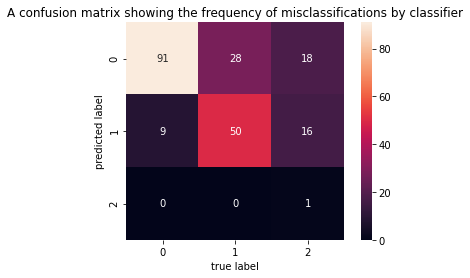

In [179]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), allTweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = False, oversample = False)

## SVM: TFIDF and Undersampling

Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  52.112676056338024
F1Score 0.4940291367688628
Precision 0.5117671843023955
Recall 0.5211267605633803
Sensitivity: 75.51%
Specificity: 75.00%


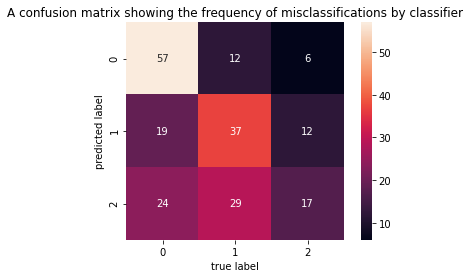

In [180]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), allTweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = True, oversample = False)

## SVM: TFIDF and Oversampling

Feature Extraction using TFIFD
Oversampling the dataset


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


Accuracy Score ->  63.38028169014085
F1Score 0.5393223010244287
Precision 0.6849171954805757
Recall 0.6338028169014085
Sensitivity: 62.69%
Specificity: 90.43%


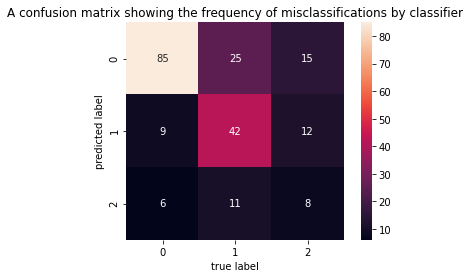

In [181]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), allTweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = False, oversample = True)

## SVM: Count and Original Data

Feature Extraction using count
Accuracy Score ->  57.74647887323944
F1Score 0.47381121206624566
Precision 0.6311145505511703
Recall 0.5774647887323944
Sensitivity: 57.97%
Specificity: 82.98%


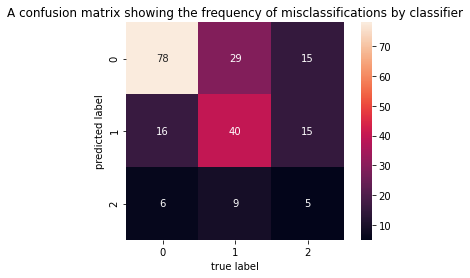

In [182]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), allTweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = False, oversample = False)

## SVM: Count and Undersampling

Feature Extraction using count
Undersampling the dataset
Accuracy Score ->  54.460093896713616
F1Score 0.494390358130147
Precision 0.5279678068410463
Recall 0.5446009389671361
Sensitivity: 68.42%
Specificity: 76.47%


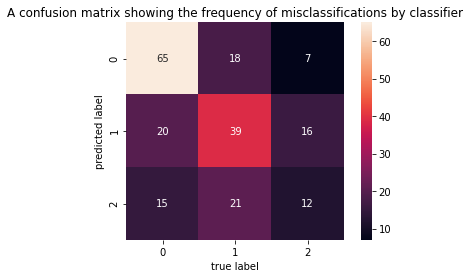

In [183]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), allTweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = True, oversample = False)

## SVM: Count and Oversampling

Feature Extraction using count
Oversampling the dataset


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


Accuracy Score ->  52.112676056338024
F1Score 0.4307738886274184
Precision 0.5457483361708714
Recall 0.5211267605633803
Sensitivity: 55.00%
Specificity: 83.91%


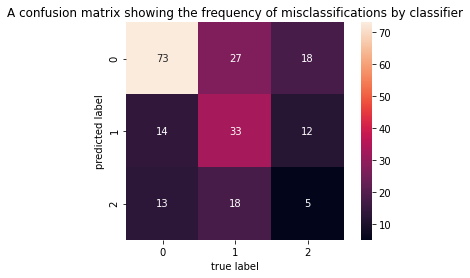

In [184]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), allTweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = False, oversample = True)

## Random Forest: Count and Original Dataset

Feature Extraction using count
Accuracy Score ->  50.23474178403756
Precision: 0.9353485012639943
Recall: 0.5023474178403756
F1Score: 0.6536429548795603
Sensitivity: 11.54%
Specificity: 98.00%


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


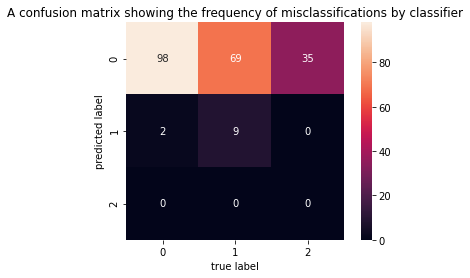

In [186]:
from sklearn.ensemble import RandomForestClassifier

modelBuild(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), allTweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = False, oversample = False)


## Random Forest: Count and Undersampling

Feature Extraction using count
Undersampling the dataset
Accuracy Score ->  63.84976525821596
Precision: 0.6363112005365527
Recall: 0.6384976525821596
F1Score: 0.637402551543923
Sensitivity: 79.66%
Specificity: 82.98%


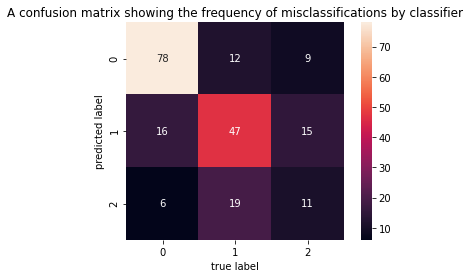

In [187]:

modelBuild(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), allTweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = True, oversample = False)


## Random Forest: Count and OverSampling

Feature Extraction using count
Oversampling the dataset


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


Accuracy Score ->  40.845070422535215
Precision: 0.5689955115307228
Recall: 0.4084507042253521
F1Score: 0.4755384258273829
Sensitivity: 9.80%
Specificity: 100.00%


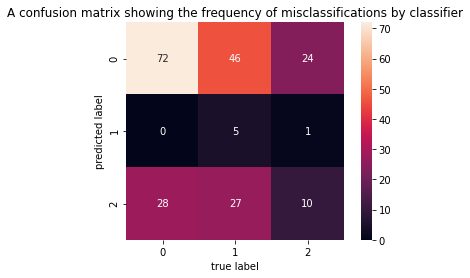

In [188]:
modelBuild(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), allTweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = False, oversample = True)


## Random Forest: TFIDF and Original Data

Feature Extraction using TFIFD
Accuracy Score ->  50.70422535211267
Precision: 0.966293487420248
Recall: 0.5070422535211268
F1Score: 0.6650916200693006
Sensitivity: 10.26%
Specificity: 100.00%


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


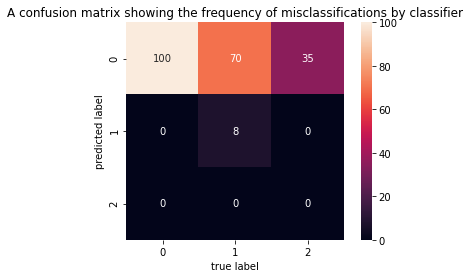

In [189]:
modelBuild(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), allTweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = False, oversample = False)


## Random Forest: TFIDF and Undersampling

Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  59.624413145539904
Precision: 0.587813547954393
Recall: 0.596244131455399
F1Score: 0.5919988264971766
Sensitivity: 82.54%
Specificity: 79.76%


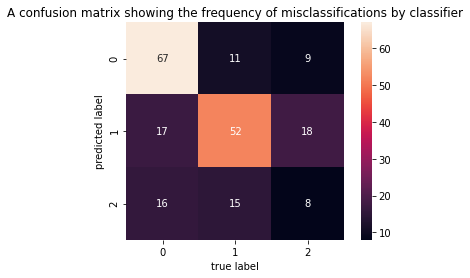

In [190]:
modelBuild(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), allTweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = True, oversample = False)


## Random Forest: TFIDF and Oversampling

Feature Extraction using TFIFD
Oversampling the dataset


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


Accuracy Score ->  48.35680751173709
Precision: 0.8629905931314381
Recall: 0.4835680751173708
F1Score: 0.619824014809073
Sensitivity: 3.12%
Specificity: 100.00%


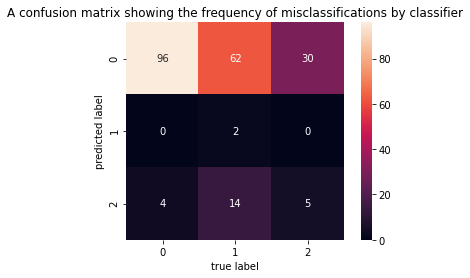

In [191]:
modelBuild(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), allTweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = False, oversample = True)

## Deep learning:LSTM

In [192]:
## split dataset into training set and validation set
from sklearn.model_selection import train_test_split
training_Tweets, val_Tweets, training_labels, val_labels = train_test_split(train_Tweets, train_labels, stratify=train_labels, test_size=0.2)



## Tokenize tweets

In [193]:
max_features = 50000 
maxlen = 100

In [194]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(training_Tweets))
training_Tweets = tokenizer.texts_to_sequences(training_Tweets)
val_Tweets = tokenizer.texts_to_sequences(val_Tweets)
test_Tweets = tokenizer.texts_to_sequences(test_Tweets)

## Pad the tweets

In [195]:
training_Tweets = pad_sequences(training_Tweets, maxlen=maxlen)
test_Tweets = pad_sequences(test_Tweets, maxlen=maxlen)
val_Tweets = pad_sequences(val_Tweets, maxlen=maxlen)

In [196]:
S_DROPOUT = 0.4
DROPOUT = 0.1

In [197]:
## plotting function
def plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()    

## Model Build

In [198]:
embed_size = 100

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          5000000   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         84480     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0     

Epoch 1/15
49/49 [==============================] - 8s 116ms/step - loss: 0.6867 - accuracy: 0.4842 - val_loss: 0.6658 - val_accuracy: 0.6714
Epoch 2/15
49/49 [==============================] - 5s 102ms/step - loss: 0.5195 - accuracy: 0.6842 - val_loss: 0.5829 - val_accuracy: 0.6946
Epoch 3/15
49/49 [==============================] - 5s 102ms/step - loss: 0.1753 - accuracy: 0.7600 - val_loss: 0.7700 - val_accuracy: 0.6881
Epoch 4/15
49/49 [==============================] - 5s 102ms/step - loss: -0.4133 - accuracy: 0.7929 - val_loss: 1.3264 - val_accuracy: 0.6662
Epoch 5/15
49/49 [==============================] - 5s 101ms/step - loss: -1.4430 - accuracy: 0.8155 - val_loss: 2.3526 - val_accuracy: 0.6740
Epoch 6/15
49/49 [==============================] - 5s 102ms/step - loss: -3.1422 - accuracy: 0.8271 - val_loss: 4.0152 - val_accuracy: 0.5838
Epoch 7/15
49/49 [==============================] - 5s 102ms/step - loss: -5.6854 - accuracy: 0.8161 - val_loss: 7.3488 - val_accuracy: 0.6070
Ep

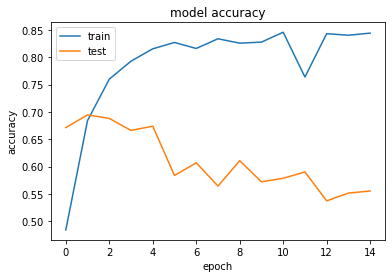

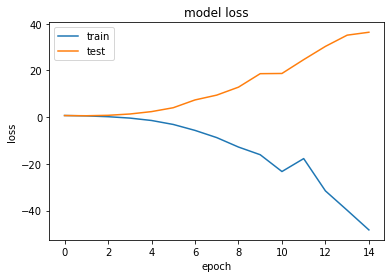

Test Accuracy: 54.929578


In [199]:
#Tweets_resampled, labels_resampled = training_Tweets, training_labels

history = model.fit(training_Tweets, training_labels, batch_size=64, epochs=15, validation_data=(val_Tweets, val_labels))
plot(history)

loss, accuracy = model.evaluate(test_Tweets, test_labels, verbose=0)
print('Test Accuracy: %f' % (accuracy*100))


In [200]:
pred_val_labels = model.predict([val_Tweets], batch_size=1024, verbose=1)

1/1 [==============================] - 1s 804ms/step


In [201]:
pred_val_labels[pred_val_labels>=0.5] = 1
pred_val_labels[pred_val_labels<0.5] = 0

In [202]:
pred_test_labels = model.predict([test_Tweets], batch_size=1024, verbose=1)

1/1 [==============================] - 0s 90ms/step


In [203]:
pred_test_labels[pred_test_labels>=0.5] = 1
pred_test_labels[pred_test_labels<0.5] = 0

unique, counts = np.unique(pred_test_labels, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0. 112.]
 [  1. 101.]]


Sensitivity: 60.26%
Specificity: 70.00%


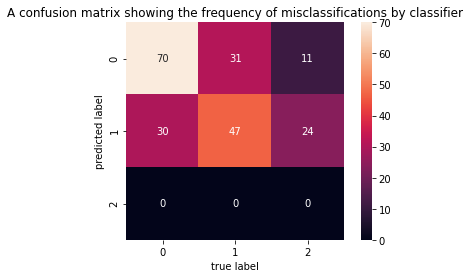

In [204]:
confusionMatrix(test_labels, pred_test_labels)

In [205]:
from sklearn import metrics


print(f1_score(pred_test_labels, test_labels, average="macro"))
print(precision_score(pred_test_labels, test_labels, average="macro"))
print(recall_score(pred_test_labels, test_labels, average="macro"))

0.39517234109834504
0.43418803418803414
0.3634488448844884


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##  GloVe Embeddings

In [206]:
from numpy import asarray

embed_size = 200

embeddings_index = dict()
f = open(root+'glove.twitter.27B.200d.txt', encoding="utf8")
for line in f:
    
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


In [207]:
from numpy import zeros

embedding_matrix = zeros((max_features, embed_size))
for word, i in tokenizer.word_index.items():
    
    
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        embedding_matrix[i] = embedding_vector

In [208]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(200, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 200)          10000000  
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 400)         641600    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 16)                6416      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0   

Epoch 1/15
49/49 [==============================] - 19s 346ms/step - loss: 0.5473 - accuracy: 0.6255 - val_loss: 0.4719 - val_accuracy: 0.7216
Epoch 2/15
49/49 [==============================] - 16s 334ms/step - loss: 0.3991 - accuracy: 0.7019 - val_loss: 0.4362 - val_accuracy: 0.7307
Epoch 3/15
49/49 [==============================] - 16s 323ms/step - loss: 0.3131 - accuracy: 0.7068 - val_loss: 0.4458 - val_accuracy: 0.6804
Epoch 4/15
49/49 [==============================] - 16s 325ms/step - loss: 0.2495 - accuracy: 0.7103 - val_loss: 0.7182 - val_accuracy: 0.6830
Epoch 5/15
49/49 [==============================] - 16s 323ms/step - loss: -0.2546 - accuracy: 0.7668 - val_loss: 1.0224 - val_accuracy: 0.6727
Epoch 6/15
49/49 [==============================] - 16s 323ms/step - loss: -1.0048 - accuracy: 0.7690 - val_loss: 0.6561 - val_accuracy: 0.6598
Epoch 7/15
49/49 [==============================] - 16s 325ms/step - loss: -2.3168 - accuracy: 0.7803 - val_loss: 4.2055 - val_accuracy: 0.6

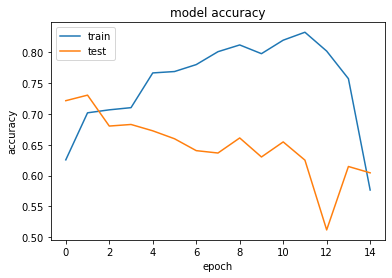

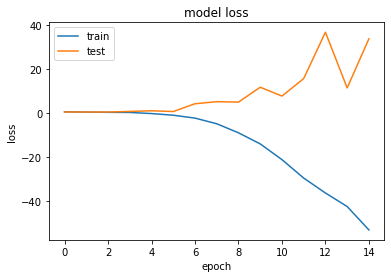

Test Accuracy: 54.929578


In [209]:
history = model.fit(training_Tweets, training_labels, batch_size=64, epochs=15, validation_data=(val_Tweets, val_labels))
plot(history)

loss, acc = model.evaluate(test_Tweets, test_labels, verbose=0)
print('Test Accuracy: %f' % (accuracy*100))



In [210]:
pred_val_labels = model.predict([val_Tweets], batch_size=1024, verbose=1)

1/1 [==============================] - 1s 1s/step


In [211]:
pred_val_labels[pred_val_labels>=0.5] = 1
pred_val_labels[pred_val_labels<0.5] = 0

In [212]:
pred_test_labels = model.predict([test_Tweets], batch_size=1024, verbose=1)

1/1 [==============================] - 0s 235ms/step


In [213]:
pred_test_labels[pred_test_labels>=0.5] = 1
pred_test_labels[pred_test_labels<0.5] = 0

unique, counts = np.unique(pred_test_labels, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0. 102.]
 [  1. 111.]]


Sensitivity: 70.51%
Specificity: 69.00%


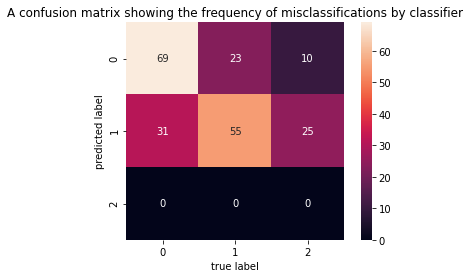

In [214]:
confusionMatrix(test_labels, pred_test_labels)

In [216]:
from sklearn import metrics


print(f1_score(pred_test_labels, test_labels, average="macro"))
print(precision_score(pred_test_labels, test_labels, average="macro"))
print(recall_score(pred_test_labels, test_labels, average="macro"))

0.4217262996140884
0.4650427350427351
0.39065536124359657


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
